In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load final dataset
df = pd.read_csv("../data/risk_segmented_data.csv")

df.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Dependent_count',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'calculated_utilization', 'High_Utilization_Flag',
       'Low_Utilization_Flag', 'Credit_Headroom', 'avg_transaction_value',
       'Transaction_Intensity', 'Inactivity_Rate', 'High_Contact_Flag',
       'Inactive_Customer_Flag', 'High_Value_Customer_Flag', 'Churn_Binary',
       'Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Unknown', 'Income_Category_$40K - $60K',
       'Income_Categ

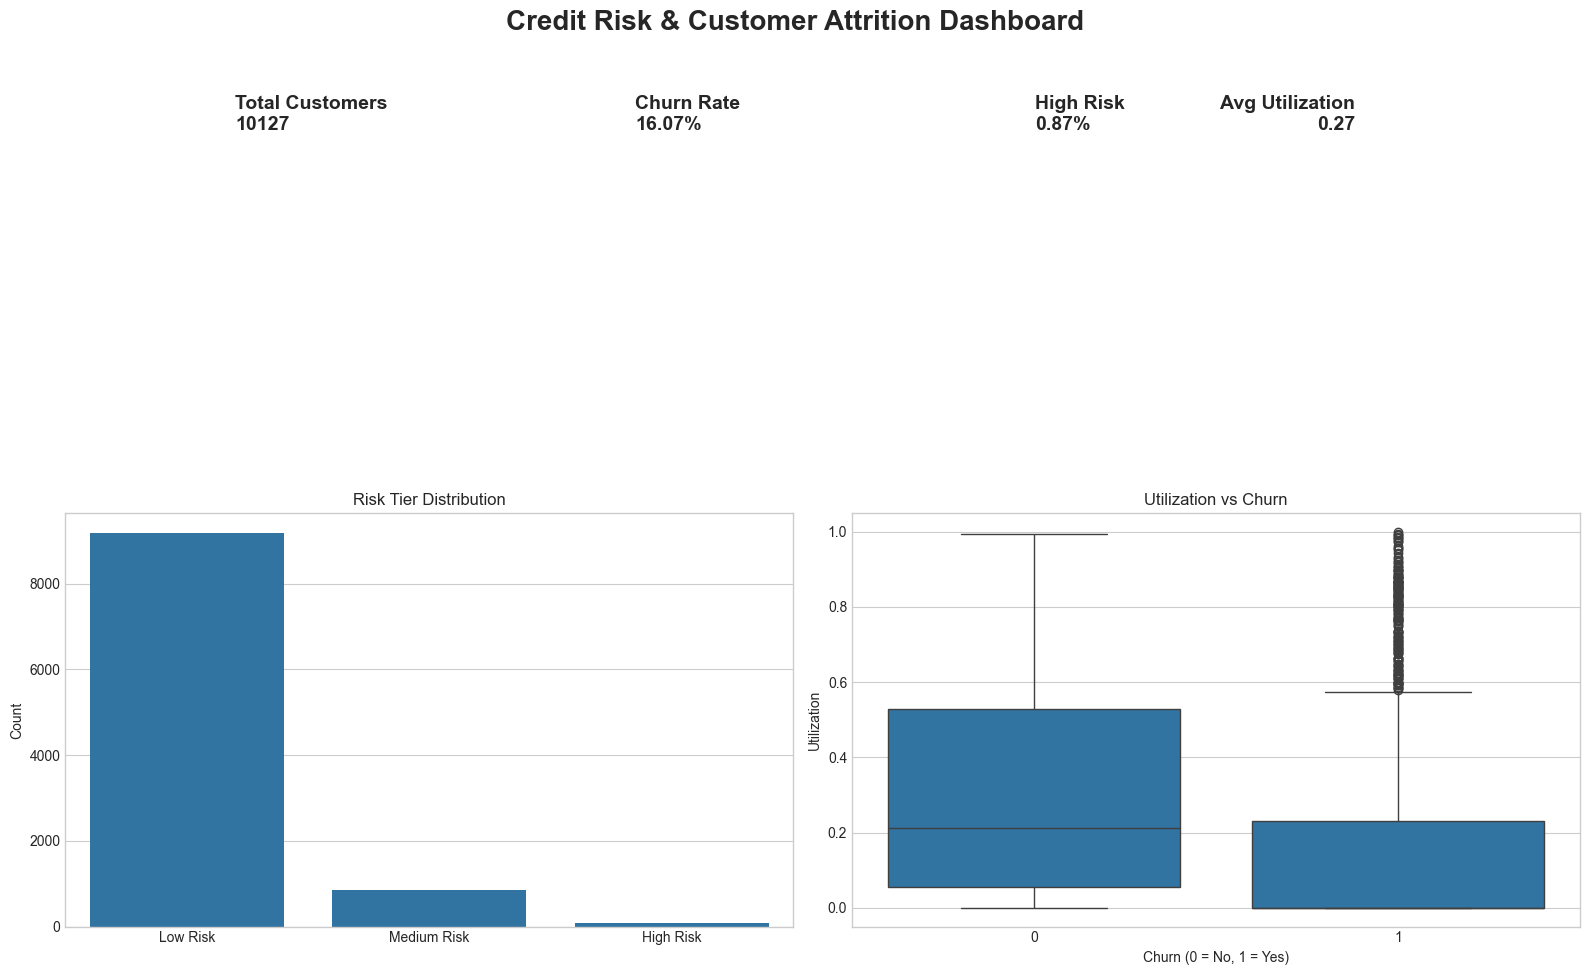

In [9]:
# ===== KPIs =====
total_customers = len(df)
churn_rate = round(df["Churn_Binary"].mean() * 100, 2)
high_risk_pct = round((df["Risk_Tier"] == "High Risk").mean() * 100, 2)
avg_util = round(df["calculated_utilization"].mean(), 2)

# ===== STYLE =====
plt.style.use("seaborn-v0_8-whitegrid")
fig = plt.figure(figsize=(16,10))

# ===== TITLE =====
fig.text(0.5, 0.95, "Credit Risk & Customer Attrition Dashboard",
         ha="center", fontsize=20, fontweight="bold")

# ===== KPI SECTION =====
fig.text(0.15, 0.85, f"Total Customers\n{total_customers}", fontsize=14, weight="bold")
fig.text(0.40, 0.85, f"Churn Rate\n{churn_rate}%", fontsize=14, weight="bold")
fig.text(0.65, 0.85, f"High Risk\n{high_risk_pct}%", fontsize=14, weight="bold")
fig.text(0.85, 0.85, f"Avg Utilization\n{avg_util}", fontsize=14, weight="bold", ha="right")

# ===== Risk Tier Distribution =====
ax1 = plt.subplot2grid((2,2), (1,0))
sns.countplot(data=df, x="Risk_Tier", ax=ax1)
ax1.set_title("Risk Tier Distribution")
ax1.set_xlabel("")
ax1.set_ylabel("Count")

# ===== Utilization vs Churn =====
ax2 = plt.subplot2grid((2,2), (1,1))
sns.boxplot(data=df, x="Churn_Binary", y="calculated_utilization", ax=ax2)
ax2.set_title("Utilization vs Churn")
ax2.set_xlabel("Churn (0 = No, 1 = Yes)")
ax2.set_ylabel("Utilization")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("professional_credit_dashboard.png", dpi=300)
plt.show()